#### LiuID: Hodfa840
#### name: Hoda

In [22]:
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.integrate import quad

In [23]:
import torch
from torch import nn
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
import warnings
warnings.filterwarnings('ignore')


In [24]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


Using device: cuda



In [25]:
class NormalDataset(Dataset):
    def __init__(self, samples, mean, std):
        self.mean = mean
        self.std = std
        rng = default_rng()
        self.data = rng.normal(loc = self.mean, scale = self.std, size=samples)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        return self.data[i]

In [26]:
rng = default_rng()
mean = 0
std = 1

def generate_noise(length):
    return rng.uniform(mean, std, length)

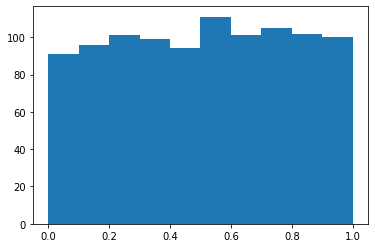

In [27]:
plt.hist(generate_noise(1000))
plt.show()

In [28]:
data = NormalDataset(10000, 0, 1)

In [29]:
dense = np.histogram(data.data,density=True)

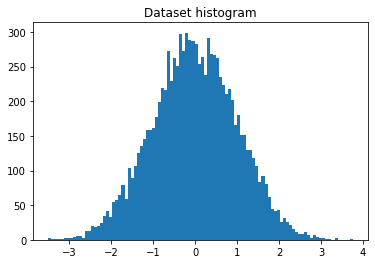

In [30]:
plt.hist(data, bins=100)
plt.title('Dataset histogram')
plt.show()

In [31]:
n_training = round(0.9 * len(data))
n_testing = len(data) - n_training
train_data, test_data = torch.utils.data.random_split(data, [n_training, n_testing])

In [32]:
epochs = 10

In [33]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=8)

In [34]:
generator_width = 100
generator_input_size = 64

generator = nn.Sequential(
    nn.Linear(generator_input_size, generator_width),
    nn.ReLU(),
    nn.Linear(generator_width, generator_width),
    
  
    nn.LeakyReLU(0.05),
    nn.Linear(generator_width, generator_width//2),
    nn.BatchNorm1d(generator_width//2),
    nn.LeakyReLU(0.05),
    nn.Linear(generator_width//2, generator_width//4),
    nn.BatchNorm1d(generator_width//4),
    nn.LeakyReLU(0.01),
    nn.Linear(generator_width//4, 1),
)

In [35]:
discriminator_width = generator_width

discriminator = nn.Sequential(
    nn.Linear(1, discriminator_width),
    nn.ReLU(),
    nn.Linear(discriminator_width, discriminator_width),
    nn.LeakyReLU(0.05),
    nn.Linear(discriminator_width, discriminator_width//2),
    nn.BatchNorm1d(generator_width//2),
    nn.LeakyReLU(0.05),
    nn.Linear(discriminator_width//2,discriminator_width//4),
     nn.LeakyReLU(0.05),
    nn.Linear(discriminator_width//4, 1),
    nn.LeakyReLU(0.01),
    nn.Sigmoid()
)

In [36]:
generator_optimizer = torch.optim.Adam(generator.parameters(),betas=(0.5,0.999), lr=5e-3)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),betas=(0.5,0.999), lr=5e-3)
criterion = nn.BCELoss()

Epoch 10  Generator loss: 0.69449  Discriminator loss: 0.69316


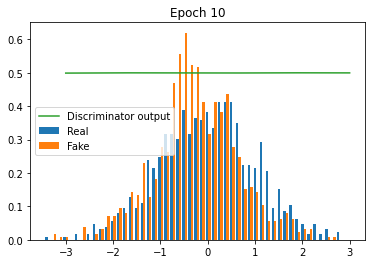

In [37]:
for epoch in range(1, epochs + 1):
    discriminator_loss_epoch = 0
    generator_loss_epoch = 0
    
    for batch_real in train_loader:
        # Train the discriminator
        batch_real = torch.tensor(batch_real, dtype=torch.float)
        batch_real = batch_real.reshape(-1, 1)

        noise = generate_noise(len(batch_real) * generator_input_size)
        noise = torch.tensor(noise, dtype=torch.float)
        noise = noise.reshape(-1, generator_input_size)
        generated = generator(noise)
        
        discriminator_optimizer.zero_grad()
        
        fake = discriminator(generated)
        real = discriminator(batch_real)
        ############### max log(D(x)) + log(1 - D(G(z)))
        lossD_real = criterion(real, torch.ones_like(real))
        lossD_fake = criterion(fake, torch.zeros_like(fake))
        discriminator_loss = (lossD_real + lossD_fake) / 2
        discriminator.zero_grad()
        ###############
        discriminator_loss.backward(retain_graph=True)
        discriminator_optimizer.step()
        
        # Train the generator min log(1 - D(G(z))) <-> max log(D(G(z))
        noise = generate_noise(len(batch_real) * generator_input_size)
        noise = torch.tensor(noise, dtype=torch.float)
        noise = noise.reshape(-1, generator_input_size)

        generator_optimizer.zero_grad()
        generated = generator(noise)
        
        fake1 = discriminator(generated)
        
        generator_loss = criterion(fake1, torch.ones_like(fake1))
        generator.zero_grad()
        generator_loss.backward()
        generator_optimizer.step()
        
        generator_loss_epoch += generator_loss.item() * batch_real.size(0)
        discriminator_loss_epoch += discriminator_loss.item() * batch_real.size(0)

    
    generator_loss_epoch = generator_loss_epoch / len(train_loader.dataset)
    discriminator_loss_epoch = discriminator_loss_epoch / len(train_loader.dataset)
    #print(f"Epoch {epoch}  Generator loss: {generator_loss_epoch:.3}  Discriminator loss: {discriminator_loss_epoch:.3}")
        
    if np.isnan(generator_loss_epoch) or np.isnan(discriminator_loss_epoch):
        print("Breaking due to NaN")
        break
      
    if epoch % 10 == 0:
        print(f"Epoch {epoch}  Generator loss: {generator_loss_epoch:.5}  Discriminator loss: {discriminator_loss_epoch:.5}")
    if epoch % 10 == 0:
        with torch.no_grad():
            real = []
            fake = []
            
            for batch_real in test_loader:
                batch_real = batch_real.float()
                batch_real = batch_real.reshape(-1, 1)
    
                noise = generate_noise(len(batch_real) * generator_input_size)
                noise = torch.tensor(noise, dtype=torch.float)
                noise = noise.reshape(-1, generator_input_size)
                
                generated = generator(noise)

                fake.append(generated)
                real.append(batch_real)
                
            fake = torch.concat(fake)
            real = torch.concat(real)
            
            fake = np.array(fake).reshape(-1)
            real = np.array(real).reshape(-1)
            
            xs_eval = torch.linspace(mean - 3 * std, mean + 3 * std, 1000)

            plt.figure()
            plt.hist([real, fake], label=['Real', 'Fake'], density=True, bins=50)
            plt.plot(xs_eval, discriminator(xs_eval.reshape(-1, 1)), label='Discriminator output')
            plt.legend()
            plt.title(f"Epoch {epoch}")
            plt.show()
        
        # optimizer.zero_grad()
        
        # outputs = model(inputs)
        
        # loss = torch.mean((outputs - labels) ** 2)
        # loss.backward()
        # optimizer.step()
        
        # train_loss += loss.item() * inputs.size(0)
        
    # train_loss = train_loss / len(train_loader.dataset)
    # print(f"Epoch {i+1}: {train_loss}")

In [52]:
def train(epochs):
    
    for epoch in range(1, epochs + 1):
        discriminator_loss_epoch = 0
        generator_loss_epoch = 0
    
        for batch_real in train_loader:
        # Train the discriminator
            batch_real = torch.tensor(batch_real, dtype=torch.float)
            batch_real = batch_real.reshape(-1, 1)

            noise = generate_noise(len(batch_real) * generator_input_size)
            noise = torch.tensor(noise, dtype=torch.float)
            noise = noise.reshape(-1, generator_input_size)
            generated = generator(noise)
        
            discriminator_optimizer.zero_grad()
        
            fake = discriminator(generated)
            real = discriminator(batch_real)
            ############### max log(D(x)) + log(1 - D(G(z)))
            lossD_real = criterion(real, torch.ones_like(real))
            lossD_fake = criterion(fake, torch.zeros_like(fake))
            discriminator_loss = (lossD_real + lossD_fake) / 2
            discriminator.zero_grad()
        ###############
            discriminator_loss.backward(retain_graph=True)
            discriminator_optimizer.step()
        
        # Train the generator min log(1 - D(G(z))) <-> max log(D(G(z))
            noise = generate_noise(len(batch_real) * generator_input_size)
            noise = torch.tensor(noise, dtype=torch.float)
            noise = noise.reshape(-1, generator_input_size)

            generator_optimizer.zero_grad()
            generated = generator(noise)
            
            fake1 = discriminator(generated)
            
            generator_loss = criterion(fake1, torch.ones_like(fake1))
            generator.zero_grad()
            generator_loss.backward()
            generator_optimizer.step()
        
            generator_loss_epoch += generator_loss.item() * batch_real.size(0)
            discriminator_loss_epoch += discriminator_loss.item() * batch_real.size(0)

    
        generator_loss_epoch = generator_loss_epoch / len(train_loader.dataset)
        discriminator_loss_epoch = discriminator_loss_epoch / len(train_loader.dataset)
    #print(f"Epoch {epoch}  Generator loss: {generator_loss_epoch:.3}  Discriminator loss: {discriminator_loss_epoch:.3}")
        
        if np.isnan(generator_loss_epoch) or np.isnan(discriminator_loss_epoch):
            print("Breaking due to NaN")
            break
    return generator_loss_epoch

    


In [39]:
train(epochs = 10)

0.6941195645862156

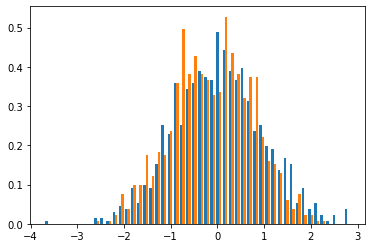

In [19]:
plt.hist([real, fake], label=['Real', 'Fake'], density=True, bins=50)
plt.show()

-2.5895193

In [36]:
xmin = np.min([real,fake])
xmax = np.max([real,fake])

In [37]:
xmax

2.8428352

In [38]:
n_bins = 50
bins = np.linspace(xmin, xmax, n_bins)
h1, edges = np.histogram(fake, bins=bins)
h2, edges = np.histogram(real, bins=bins)

h1 = h1 / np.sum(h1)
h2 = h2 / np.sum(h2)

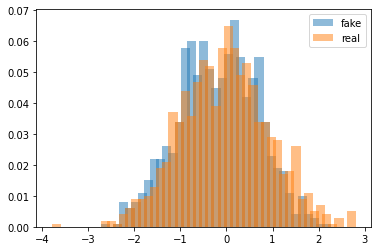

In [41]:
plt.bar(edges[:-1], h1, alpha = 0.5, width = 0.2,label = 'fake')
plt.bar(edges[:-1], h2, alpha = 0.5, width = 0.2,label = 'real')
plt.legend()
plt.show()

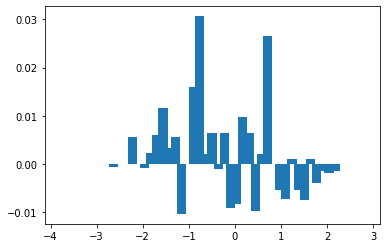

In [44]:
sumover =  h1 * np.log((h1 + 1e-6) / (h2 + 1e-6))

plt.bar(edges[:-1], sumover,width = 0.2)
# plt.bar(edges[:-1], h1, alpha = 0.5, width = 0.2)
# plt.bar(edges[:-1], h2, alpha = 0.5, width = 0.2)
plt.show()

In [46]:
discrete_kl = np.sum(sumover)
discrete_kl

0.06753085430735341

In [49]:
dis1  = fake
dist2 = real
x = np.linspace(xmin, xmax, 100)


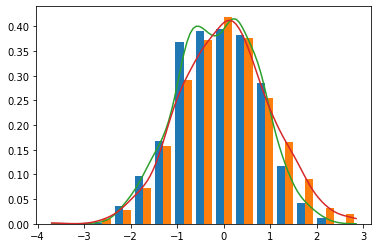

In [52]:
n_samples = 10000
draws1 = fake
draws2 = real

# bw_method = .5
bw_method = 'scott'
kde1 = gaussian_kde(draws1, bw_method=bw_method)
kde2 = gaussian_kde(draws2, bw_method=bw_method)

plt.hist([draws1, draws2], bins=15, density=True)
plt.plot(x, kde1(x))
plt.plot(x, kde2(x))

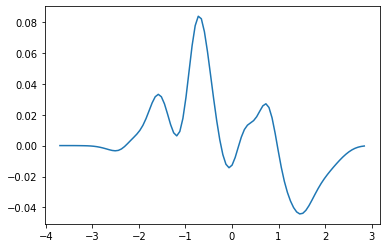

In [53]:
f = lambda x: kde1(x) * np.log((kde1(x) + 1e-6) / (kde2(x) + 1e-6))

plt.plot(x, f(x))
plt.show()

In [56]:
kernel_integral, error = quad(f, xmin, xmax)
kernel_integral, error

(0.0304216016640858, 2.1050205467488597e-11)

In [69]:
print("Numerical integration of kernels\t", kernel_integral)
print("Discretization using histograms\t\t", discrete_kl)

Numerical integration of kernels	 0.0304216016640858
Discretization using histograms		 0.06753085430735341


In [71]:
# save numpy array as npy file
from numpy import asarray
from numpy import save
# define data
data = asarray([[real],[fake]])
# save to npy file
save('model1.npy', data)

# 

In [41]:

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
#from sklearn.metrics import roc_auc_score
import sys


In [48]:
space = {
   # 'optimizer': hp.choice('optimizer', ['Adam', 'SGD','RMSprop']),
    #'lr': hp.uniform('lr_rate', 5e-4,5e-3),
    'batch_size' : hp.uniform('batch_size', 28,128),
    
}

In [49]:
trials = Trials()


In [51]:
best = fmin(train, space, algo=tpe.suggest, max_evals=50, trials=trials)


  0%|                                    | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: unsupported operand type(s) for +: 'dict' and 'int'



  0%|                                    | 0/50 [00:00<?, ?trial/s, best loss=?]


TypeError: unsupported operand type(s) for +: 'dict' and 'int'

In [ ]:
def f_nn(params):   
    
    from torch.optim import SGD, Adam, rmsprop

    generator = nn.Sequential(
    nn.Linear(generator_input_size, generator_width),
    nn.ReLU(),
    nn.Linear(generator_width, generator_width),
    
  
    nn.LeakyReLU(0.05),
    nn.Linear(generator_width, generator_width//2),
    nn.BatchNorm1d(generator_width//2),
    nn.LeakyReLU(0.05),
    nn.Linear(generator_width//2, generator_width//4),
    nn.BatchNorm1d(generator_width//4),
    nn.LeakyReLU(0.01),
    nn.Linear(generator_width//4, 1),
)
    
    


    model.fit(X, y, nb_epoch=params['nb_epochs'], batch_size=params['batch_size'], verbose = 0)

    pred_auc =model.predict_proba(X_val, batch_size = 128, verbose = 0)
    acc = roc_auc_score(y_val, pred_auc)
    print('AUC:', acc)
    sys.stdout.flush() 
    return {'loss': -acc, 'status': STATUS_OK}


trials = Trials()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=50, trials=trials)
print('best: ', best)

    print ('Params testing: ', params)
    model = Sequential()
    model.add(Dense(output_dim=params['units1'], input_dim = X.shape[1])) 
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout1']))

    model.add(Dense(output_dim=params['units2'], init = "glorot_uniform")) 
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout2']))

    if params['choice']['layers']== 'three':
        model.add(Dense(output_dim=params['choice']['units3'], init = "glorot_uniform")) 
        model.add(Activation(params['activation']))
        model.add(Dropout(params['choice']['dropout3']))    

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'])

    model.fit(X, y, nb_epoch=params['nb_epochs'], batch_size=params['batch_size'], verbose = 0)

    pred_auc =model.predict_proba(X_val, batch_size = 128, verbose = 0)
    acc = roc_auc_score(y_val, pred_auc)
    print('AUC:', acc)
    sys.stdout.flush() 
    return {'loss': -acc, 'status': STATUS_OK}


trials = Trials()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=50, trials=trials)
print('best: ', best)

In [ ]:

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score
import sys

X = []
y = []
X_val = []
y_val = []

space = {'choice': hp.choice(
                    [ 

           
           
            'batch_size' : hp.uniform('batch_size', 28,128),

            'nb_epochs' :  10,
            'optimizer': hp.choice('optimizer',['adadelta','adam','rmsprop']),
            'activation': 'relu'
                        
        }]

def f_nn(params):   

  
    model = Sequential()
    model.add(Dense(output_dim=params['units1'], input_dim = X.shape[1])) 
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout1']))

    model.add(Dense(output_dim=params['units2'], init = "glorot_uniform")) 
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout2']))

    if params['choice']['layers']== 'three':
        model.add(Dense(output_dim=params['choice']['units3'], init = "glorot_uniform")) 
        model.add(Activation(params['activation']))
        model.add(Dropout(params['choice']['dropout3']))    

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'])

    model.fit(X, y, nb_epoch=params['nb_epochs'], batch_size=params['batch_size'], verbose = 0)

    pred_auc =model.predict_proba(X_val, batch_size = 128, verbose = 0)
    acc = roc_auc_score(y_val, pred_auc)
    print('AUC:', acc)
    sys.stdout.flush() 
    return {'loss': -acc, 'status': STATUS_OK}


trials = Trials()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=50, trials=trials)
print('best: ', best)

In [7]:
from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler


In [8]:
n_training = round(0.9 * len(data))
n_testing = len(data) - n_training
train_data, test_data = torch.utils.data.random_split(data, [n_training, n_testing])

NameError: name 'data' is not defined

In [ ]:
from hyperopt import fmin, tpe, hp, Trials

from helpers import train_validate



trials = Trials()

space = {

'activation': hp.choice('activation', [nn.LeakyReLU(), nn.ReLU6(), nn.Sigmoid()]),

'n_layers': hp.uniform('n_layers', 4, 12),

'layer_size': hp.choice('layer_size', [8,16,32]),

'epochs': hp.uniform('epochs', 50, 200)

}

best = fmin(fn=, True),

space = space,

algo=tpe.suggest,

max_evals=20*4,

trials = trials)



print(best)

In [ ]:
def objective(params):
    params = {
        'activation': hp.choice('activation', [nn.LeakyReLU(), nn.ReLU6(), nn.Sigmoid()]), 
        'epochs': hp.uniform('epochs', 50, 200)
        
    }

clf = RandomForestClassifier( **params)
    score = cross_val_score(clf, X, y, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()
    #print("ROC-AUC {:.3f} params {}".format(score, params))

    return {'loss':-score, 'status': STATUS_OK }

In [71]:
epochs = np.array([10,50,100],'i')
l = [32,64,128]


In [ ]:

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=8)

In [77]:
maxiter = 10

In [79]:
loss_hist = np.zeros(shape = [len(l),len(epochs)])

In [80]:
for i in range(len(l)):
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=l[i], num_workers=8)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=l[i], num_workers=8)
    for j in range(len(epochs)):
        loss_hist[i,j] =  train(epochs[j])

In [81]:
loss_hist

array([[0.69467495, 0.70262346, 0.6990804 ],
       [0.70144451, 0.70240178, 0.70333054],
       [0.70230203, 0.69682412, 0.69662125]])

In [ ]:
import torch
import torch.nn as nn

num_samples = len(data)
input_size = 10
layer_size = 15
output_size = 5

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, layer_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(layer_size, output_size)

    def forward(self, input):
        return self.layer2(self.relu(self.layer1(input)))

# In this example we use a randomly generated dataset.
input = torch.randn(num_samples, input_size)
labels = torch.randn(num_samples, output_size)
